In [3]:
import sys
sys.path.append('..')
import jax
from jax import vmap
import numpy as np
import matplotlib.pyplot as plt
from src.util import *
from src.plot import *
from src.stokes import *
from src.gp_shapes import *

In [8]:

def normalize_vector(v, const):
    return v / const#jnp.mean(v**2)**0.5

def load_data(idx):
    return jnp.load(f"../data/data_{idx}.npy")

def load_f_data(idx):
    #return jnp.load(f"../data/f_data_{idx}.npy")
    c = load_data(idx)
    t = jnp.linspace(0, 2*jnp.pi, 101)[:-1]
    fseries = lambda c: vmap(lambda t,c: from_complex(fourier_eval_flat(t, c)), (0, None))(t, c)
    return vmap(fseries)(c)

idx_list = [0,1]
M = 1000
c_data = jnp.concatenate([load_data(idx) for idx in idx_list], axis=0)#[:M]
f_data = jnp.concatenate([load_f_data(idx) for idx in idx_list], axis=0)#[:M]

# Remove unphysical data
#c_data, f_data = filter_unphysical(c_data, f_data)
#norms = vmap(jnp.linalg.norm, 0)(f_data) / f_data.shape[1]
#c_data = c_data[norms < 10]
#f_data = f_data[norms < 10]

total_norm = jnp.mean(vmap(jnp.mean, 0)(f_data**2)**0.5)
f_data = normalize_vector(f_data, total_norm)

dist_table, theta_table, gamma_table = get_align_table(c_data, c_data, Nref = 100)
theta_table = theta_table.squeeze()

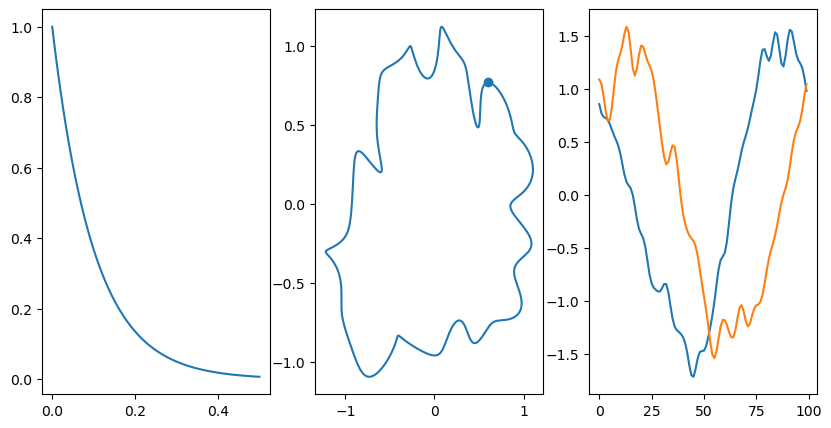

In [14]:
def to_fourier(f_data, K):
    f_data_compl = f_data[:, 0] + 1j * f_data[:, 1]
    t = jnp.linspace(0, 2*jnp.pi, f_data.shape[0]+1)[:-1]
    fc_data = fit_fourier(t, f_data_compl, K)
    return fc_data

def precompute_gp_weights(kernel, dist_table, theta_table, gamma_table, fc_data):
    K = (fc_data.shape[1] - 1) // 2
    ks = jnp.linspace(-K, K, 2*K+1)
    
    dist_table = kernel(dist_table)
    
    #Kmat = lambda k: jnp.exp(1j*k*gamma_table-1j*theta_table) * dist_table
    Kmat = lambda k: jnp.conjugate(jnp.exp(1j*k*gamma_table-1j*theta_table)) * dist_table
    
    weights = vmap(lambda k,v: jnp.linalg.solve(Kmat(k), v), (0, 1))(ks, fc_data)
    return weights

def eval_gp(c, c_data, weights, kernel):
    K = (weights.shape[0] - 1)// 2 
    ks = jnp.linspace(-K, K, 2*K+1)
    
    dists, thetas, gammas = vmap(lambda c2: align_fourier_info(c, c2), (0))(c_data)
    dists = kernel(dists)

    #Kmat = lambda k: jnp.conjugate(jnp.exp(1j*k*gammas-1j*thetas)) * dists
    Kmat = lambda k: (jnp.exp(1j*k*gammas-1j*thetas)) * dists
    evals = jnp.einsum("kn, kni -> ki", vmap(Kmat)(ks), weights)
    return evals, vmap(lambda k: Kmat(k), 0)(ks)

K = 10
fc_data = vmap(to_fourier, (0, None))(f_data, K)

option = 3
if option == 1:
    sigma = 0.02
    kernel = lambda r: 1-1/(1+jnp.exp(8 - r/sigma))#jnp.exp(-r/sigma)
elif option == 2:
    sigma = 0.01
    kernel = lambda r: jnp.exp(-r/sigma)
elif option == 3:
    sigma = 0.1
    kernel = lambda r: jnp.exp(-r/sigma)
    
weights = precompute_gp_weights(kernel, dist_table, theta_table, gamma_table, fc_data)


plt.figure(figsize=(10, 5))
plt.subplot(131)
r = jnp.linspace(0, 0.5, 100)
plt.plot(r, kernel(r))

plt.subplot(132)
w_norms = vmap(jnp.linalg.norm, 1)(weights)
w_max = jnp.argmax(w_norms)
plot_fourier_curve(c_data[w_max])

plt.subplot(133)
plt.plot(f_data[w_max, :, 0])
plt.plot(f_data[w_max, :, 1])

(21, 2000, 1)


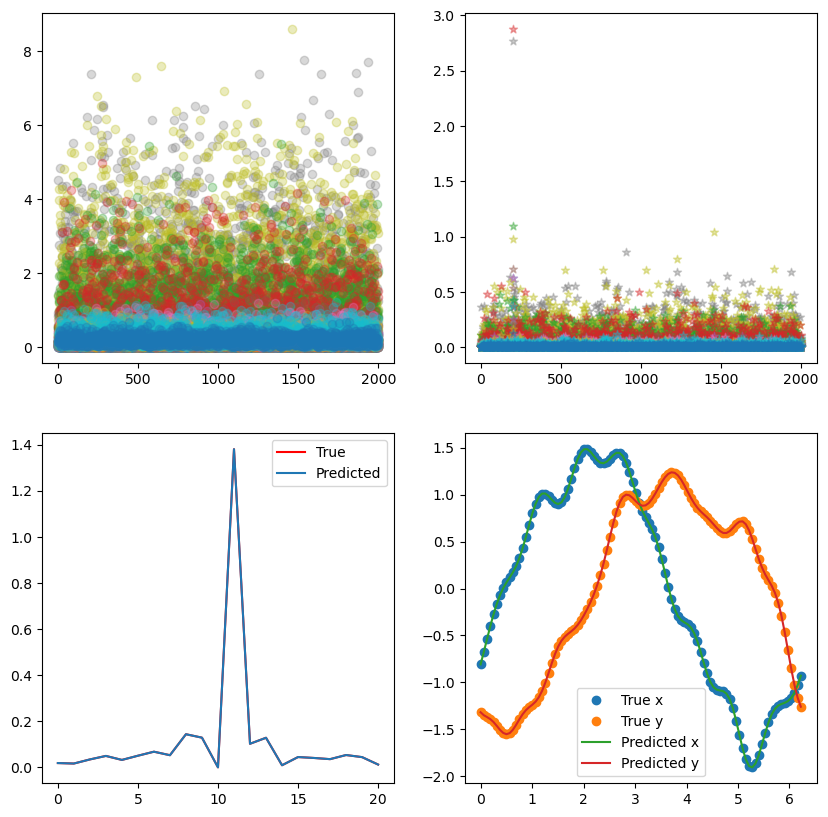

In [31]:
i_test = 200
idx_test = 0

c = load_data(idx_test)[i_test]
f = load_f_data(idx_test)[i_test]
f = normalize_vector(f, total_norm)
fc = to_fourier(f, K)

fc_pred, rbfs = eval_gp(c, c_data, weights, kernel)
#phase = jnp.exp(1j * jnp.pi * 0.35)
#fc_pred2, _ = eval_gp(c*phase, c_data, weights, kernel)
#fc_pred2 = fc_pred2 * jnp.conjugate(phase)

t = jnp.linspace(0, 2*jnp.pi, 101)[:-1]
f = fourier_eval(t, fc)
f_pred = fourier_eval(t, fc_pred)
#f_pred2 = fourier_eval(t, fc_pred2)

plt.figure(figsize=(10,10))
plt.subplot(221)
Ns = jnp.arange(fc_data.shape[0])
for i in range(fc_data.shape[1]):
    plt.scatter(Ns, jnp.abs(weights[i, :]), alpha=0.3)
    #plt.scatter(Ns, jnp.abs(fc_data[:, i]).squeeze(), marker='*', alpha=0.3)
plt.subplot(222)
for i in range(fc_data.shape[1]):
    plt.scatter(Ns, jnp.abs(rbfs[i].squeeze()*weights[i, :].squeeze()), marker='*', alpha=0.4)

plt.subplot(223)
print(weights.shape)
plt.plot((jnp.abs(fc)), 'red', label='True')
plt.plot((jnp.abs(fc_pred)), label='Predicted')
#plt.plot((jnp.abs(fc_pred2)), label='Predicted 2')
#phase = jnp.sum(fc)/jnp.sum(fc_pred)
#plt.plot(fc.real, 'red', label='True')
#plt.plot((fc_pred*phase).real, label='Predicted')
#plt.plot(rbfs[i_test])
plt.legend()

plt.subplot(224)
plt.plot(t, f.real, 'o', label='True x')   
plt.plot(t, f.imag, 'o', label='True y')   
plt.plot(t, f_pred.real, label='Predicted x')
plt.plot(t, f_pred.imag, label='Predicted y')
#plt.plot(t, f_pred2.real, '--', label='Equivariance check x')
plt.legend()


In [ ]:

plt.figure()
for i in range(80):
    plt.plot(f_data[i, :, 0])

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(dist_table)
plt.subplot(132)
plt.imshow(theta_table)
plt.subplot(133)
plt.imshow(gamma_table)

plt.figure()
plt.hist(dist_table.flatten(), bins=100)
None